# Data Ingestion

In [1]:
# data manipulation
import pandas as pd
import geopandas as gpd

# connecting to the local database with the data
import psycopg2

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as cx

# establish connection with the database
conn = psycopg2.connect("dbname=bikemi user=luca")

ModuleNotFoundError: No module named 'pandas'

The data was made available thanks to a partnership established by Prof. Giancarlo Manzi of the University of Milan and Clear Channel, the provider of the service. The data is comprised of all the individual trips performed by each client (cliente_anonimizzato). This includes the bike type (which can either be a regular bike or an electric bike), the bike identifier, the station of departure and arrival with the time, plus the total travel distance.

In [ ]:
query = """
    SELECT *
    FROM bikemi_rentals
    LIMIT 5;
"""

pd.read_sql(sql=query, con=conn)

The data available ranges from the first of June, 2015, to the first of October, 2020, totalling to 15842891 observations. Besides, data was made available in Excel spreadsheets, following the [Office Open XML SpreadsheetML File Format](https://docs.microsoft.com/en-us/openspecs/office_standards/ms-xlsx/f780b2d6-8252-4074-9fe3-5d7bc4830968) (the `.xlsx` file format). Python's Pandas library has methods to read `.xlsx` files; however, given how big these files are, data manipulation would have proven unfeasible.

For this reason, we resorted to some useful and popular open source tools, which we used to build `bash` scripts and functions to automate conversion from `.xlsx` to `.csv` files, perform some elementary data cleaning and load the data into a local PostgreSQL database. Format conversion to Comma-Separated Values (`.csv`) was performed using [`csvkit`](https://github.com/wireservice/csvkit), a Python package to perform basic operations on `.csv` files from the command line. Being written in Python, `csvkit` can be slow. However, as part of a major trend for several command-line applications, `csvkit` was rewritten in Rust, a fast and secure programming language whose popularity has been rising in the last couple of years <cite id=\"jc6it\">(Perkel, 2020)</cite>. Much alike Julia <cite id=\"54bj7\">(Perkel, 2019)</cite>, Rust is becoming a tool for data science, as well as scientific computing (for example in bio-statistics) as it is \"a language that offer[s] the 'expressiveness' of Python but the speed of languages such as C and C++\" <cite id=\"k79mf\">(Perkel, 2020)</cite>.

The Rust port of `csvkit` is called [`xsv`](https://github.com/BurntSushi/xsv), and is blazing fast. Much alike `awk` <cite id="tcloo">(<i>Gawk - GNU Project - Free Software Foundation (FSF)</i>, n.d.)</cite>, `xsv` can perform filtering operations, but also joins and partitions, as well as computing summary statistics. `xsv` does not offer (yet) format conversion, but was used to filter out a negligible number of invalid observations from each original `.xslx` files (after the conversion to `.csv`), and select only the columns that would enter the final dataset.

Finally, `psql` (PostgreSQL's command line utility) was used to upload the 'clean' data into a local database instance. PostgreSQL was also used to perform basic survey statistics, like computing the number of rows, and data aggregation (such as counting the number of observations by year). Looking at the frequency tables by year, there appears to be an oddly small number of observations from 2018. This is because there is indeed missing data from June 2018 until the end of the year. For this reason, we only work with data from June 2015 to the end of May 2018.

In [ ]:
query = """
    SELECT
        EXTRACT('year' FROM b.data_prelievo) AS date,
        COUNT(b.bici)
    FROM bikemi_rentals b
    -- WHERE EXTRACT('year' FROM b.data_prelievo) < 2019
    GROUP BY EXTRACT('year' FROM b.data_prelievo);
"""

pd.read_sql(sql=query, con=conn).astype("int")

## Data Pre-processing

According to the official BikeMi website website, "BikeMi today has 320 stations distributed in the key points of the city and 5430 bicycles (4280 classic bicycles 1000 e-bikes and 150 pedal-assisted bicycles with child seat)". From the website we can access the open APIs and the live map of the stations. We can retrieve the geographic coordinates of the stations either from the API or from the excellent open data portal from the Municipality of Milan

## Retrieve Data Aggregated at Station-Level

In [9]:
# when the station_columns is specified, data for each station is retrieved
station_daily_outflow = (
    rf.retrieve_bike_flow(
        table="bikemi_2019",
        station_column=["nome_stazione_prelievo", "stazione_partenza"],
    )
    # it's easier if we don't pivot to wider immediately
    # .pipe(rf.pivot_bike_flow, cols="stazione_partenza")
    # .fillna(0) later
    .convert_dtypes().sort_values(  # make double into integers
        by=["giorno_partenza", "stazione_partenza"], ascending=False
    )
)

station_daily_outflow.tail()

,stazione_partenza,count
giorno_partenza,,
2019-01-01,Angilberto - Comacchio,2
2019-01-01,Amendola M1,2
2019-01-01,Alserio - Cola Montano,7
2019-01-01,Adamello - Lorenzini,1
2019-01-01,Accursio - Portello,2


At first glance, there appears to be quite a few missing values. We also need to get rid of the January 2020 data:

In [10]:
station_daily_outflow = station_daily_outflow.loc[
    station_daily_outflow.index != "2020-01-01"
]

Then we look into the missing data:

In [11]:
station_wide = station_daily_outflow.pivot(columns="stazione_partenza")

In [12]:
station_missing_obs = (
    station_wide.isnull()
    .sum()
    .reset_index()
    .rename(columns={"index": "station_name", 0: "missing_obs"})
)

station_missing_obs.head()

,level_0,stazione_partenza,missing_obs
0,count,Accursio - Portello,2
1,count,Adamello - Lorenzini,4
2,count,Alserio - Cola Montano,0
3,count,Amendola M1,3
4,count,Angilberto - Comacchio,40


In [13]:
station_missing_obs["pct_missing"] = station_missing_obs["missing_obs"] / 366 * 100

station_missing_obs.sort_values("pct_missing", ascending=False).head(10)

,level_0,stazione_partenza,missing_obs,pct_missing
75,count,Ciceri Visconti - Martini,348,95.081967
275,count,Tertulliano - Caroncini,346,94.535519
209,count,Primaticcio - Legioni Romane,322,87.978142
208,count,Primaticcio - Corba,290,79.234973
103,count,Duomo 2 - Foscolo,276,75.409836
38,count,Bottini 2 - Lambrate M2,272,74.316940
261,count,Soderini - Provincia di Milano,271,74.043716
63,count,Carlini - Dalviano,268,73.224044
37,count,Bottini 1 - Lambrate M2,267,72.950820
234,count,San Gimignano - Tuberose,267,72.950820


This shows - as expected - that some stations are basically not used at all, while some others are quite popular. Let's try to categorise them:

In [14]:
labels = ["very_high", "high", "average", "low", "very_low"]

station_missing_obs["usage_ranking"] = pd.cut(
    station_missing_obs["pct_missing"], bins=5, labels=labels
)

`pd.cut()` will always return a `category` `dtype`. These can also be further manipulated via [`pandas.DataFrame.cat.set_categories()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.set_categories.html) (works with `pandas.Index` and `pandas.DataFrame` too.)

We can tabulate and plot this data:

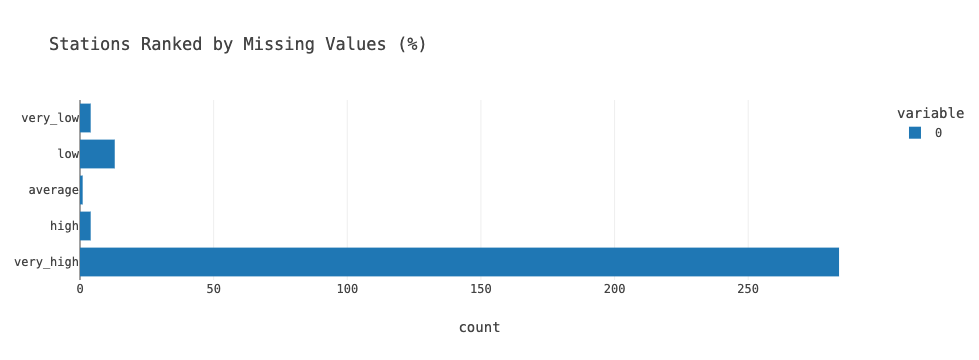

In [16]:
# `.size()` counts the number of member in each category
fig = (
    station_missing_obs.groupby("usage_ranking")
    .size()
    .plot(
        kind="barh",
        template="none",
        labels=dict(value="count", usage_ranking=""),
        title="Stations Ranked by Missing Values (%)",
    )
)

ps.plotly_style(fig)

fig.show()

Before saving the data to a `.csv` file, we should replace the missing observations with `0`:

In [17]:
station_daily_outflow.fillna(0).to_csv("../data/bikemi_csv/station_daily_outflow.csv")

We don't need to save the wide `DataFrame` too, as we can pivot the table with ease.

## Hourly Data

We could also extract hourly data, but we argued it will be noisy:

In [18]:
# we can also extract the hourly data at the aggregate level:
hourly_outflow = rf.retrieve_bike_flow(table="bikemi_2019", trunc="hour")

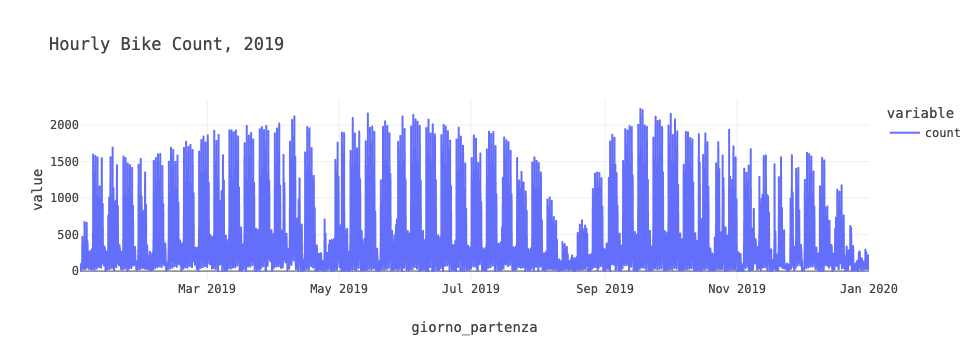

In [20]:
ps.plotly_style(hourly_outflow.plot(title="Hourly Bike Count, 2019"))